# `Progetto Open Data Management`
## _Andrea Fazio, Giuseppe Rosa_
### 21 Giugno 

***
***

# `0. Indice`
[`1. - Dataset`](#1-dataset) <br>
[`2. - Elaborazione dei dataset`](#2-elaborazione-dei-dataset) <br>
[`3. - Trasformazione dei dataset a 5 stelle`](#3-trasformazione-dei-dataset-a-5-stelle) <br>
[`4. - Data visualization`](#4-data-visualization) <br>
[`5. - Mappa istituti sicilia con uMap`](#5-mappa-istituti-sicilia-con-uMap) <br>

***
***
# `1. Dataset`

I dataset utilizzati per la realizzazione della base di conoscenza riguardano le istituzioni scolastiche e i relativi ambienti e valutazioni. L'obiettivo della base di conoscenza è racchiudere tutte le istituzioni scolastiche presenti in sicilia.

In seguito i dataset utilizzati con relativi link e licenze:

- **Ambienti e area scolastica (a.s. 2020-2021)**
> Dataset sulle informazioni al contesto ambientale degli edifici delle scuole <br>
`Link`: https://dati.istruzione.it/opendata/opendata/catalogo/elements1/leaf/?area=Edilizia%20Scolastica&datasetId=DS0111EDIAMBIENTESTA2021 <br>
`Licenza`: IODL 2.0

- **Autovalutazione della scuola sezione Esiti**
> Dataset sulle informazioni riguardanti l'autovalutazione in termini di: Risultati scolastici, Risultati nelle prove standardizzate nazionali, Competenze chiave e di cittadinanza, Risultati a distanza. Scuola statale <br>
`Link`: https://dati.istruzione.it/opendata/opendata/catalogo/elements1/leaf/?area=Sistema%20Nazionale%20di%20Valutazione&datasetId=DS0500VALUTAZIONE_ESITI_STA <br>
`Licenza`: IODL 2.0

- **Rubrica di valutazione utilizzata dalla scuola per l'autovalutazione**
> Dataset sulle informazioni riguardanti la rubrica di valutazione di ciascun criterio di qualità utilizzato per l'autovalutazione <br>
`Link`: https://dati.istruzione.it/opendata/opendata/catalogo/elements1/leaf/?area=Sistema%20Nazionale%20di%20Valutazione&datasetId=DS0540RUBRICA_VAL <br>
`Licenza`: IODL 2.0
 

- **Scuola, alunni e classi 2021-2022**
> Dataset sulle informazioni riguardanti gli alunni e le classi delle scuole di Sicilia, per l'anno 2021-2022, per il ciclo primario e secondario. <br>
`Link`: https://dati.regione.sicilia.it/catalogo/scuole-alunni-classi-2021-2022 <br>
`Licenza`: CC-BY-4.0


- **Istituzioni scolastiche**
> Dataset sulle informazioni riguardanti l’anagrafica delle istituzioni scolastiche della Sicilia <br>
`Link`: https://old.usr.sicilia.it/index.php/dati-delle-scuole/24-generale/5166-dati-delle-scuole-a-s-2021-2022.html <br>
`Licenza`: IODL 2.0

***
***
# `2. Elaborazione dei dataset`

Dopo averli analizzati, siamo passati alla fase di pulizia ed elaborazione dei dati. <br> 
Per prima cosa abbiamo rimosso le colonne non rilevanti o ridondanti dei vari dataset attraverso l'utilizzo di `Open Refine`. In alcune colonne abbiamo anche rimosso possibili spazi vuoti o accapo non previsti in maniera da garantire uniformità nei dati dei vari dataset e rimosso le righe contenente dati vuoti in quanto non davano alcuna informazione.
I dati puliti con Open Refine sono stati salvati in `dataset/cleaned`.

Successivamente in python con la libreria `pandas` abbiamo:
- Convertire in maiuscolo i codici delle scuole;
- Rinominato la colonna `Codice` in `CodiceScuola` nel dataset `anagrafiche`, per facilitarne il merge;
- Effettuare il merge tra i dataset `anagrafiche` e `alunni_classi` e rimosso le colonne duplicate;
- Rimozione delle righe duplicate nel dataset `rubrica delle valutazioni`;
- Rinominare la colonna `CODICECRITERIOQUALITA` in `CODICECRITERIO`, per facilitarne il merge;
- Effettuato il merge tra i dataset sulla `valutazioni` e la corrispondente `rubrica`;
- Filtrato le righe del dataset `valutazioni` tenendo quelle con scuole presenti nel dataset delle `anagrafiche`;
- Filtrato le righe del dataset `ambienti` tenendo quelle con scuole presenti nel dataset delle `anagrafiche`;
- Eliminazione dei duplicati nel dataset `ambienti`;
- Eliminazione delle righe con valore "NON DEFINITO" nel dataset `ambienti`;
- Sostituzione delle celle con valore "_" con "NO" per garantire l'uniformità.

Infine i dataset processati sono stati salvati nella cartella `dataset/processed`.


In [270]:
import pandas as pd

anagrafiche = pd.read_csv('dataset/cleaned/Istituzioni-scolastiche-as2021-22.csv')
alunni_classi = pd.read_csv('dataset/cleaned/scuole-alunni-classi-2021-2022.csv')


anagrafiche['Codice']=anagrafiche['Codice'].apply(lambda x: x.upper())
anagrafiche.rename(columns={'Codice':'CodiceScuola'}, inplace=True)
alunni_classi['CodiceScuola']=alunni_classi['CodiceScuola'].apply(lambda x: x.upper())

merged = pd.merge(anagrafiche, alunni_classi, on='CodiceScuola', suffixes=('', '_remove'))
merged.drop([col for col in merged.columns if 'remove' in col], axis=1, inplace=True)

valutazioni = pd.read_csv('dataset/cleaned/VALUTAZIONE-ESITI-STA.csv')
rubrica_val = pd.read_csv('dataset/cleaned/RUBRICA-VAL.csv')

ambiente = pd.read_csv('dataset/cleaned/EDIAMBIENTESTA.csv')

rubrica_val.drop_duplicates(inplace=True)
rubrica_val.rename(columns={'CODICECRITERIOQUALITA':'CODICECRITERIO'}, inplace=True)
merged_dataset = pd.merge(valutazioni, rubrica_val, on='CODICECRITERIO', suffixes=('', '_remove'))
merged_dataset.drop([col for col in merged_dataset.columns if 'remove' in col], axis=1, inplace=True)
merged_dataset.rename(columns={'CODICEISTITUTO':'CODICESCUOLA'}, inplace=True)
merged_dataset = merged_dataset[merged_dataset['CODICESCUOLA'].isin(merged['CodiceScuola'])]
merged_dataset.to_csv('dataset/processed/valutazioni.csv', index=False)

ambiente = ambiente[ambiente['CODICESCUOLA'].isin(merged['CodiceScuola'])]
ambiente.drop_duplicates(subset=['CODICESCUOLA'], keep='first', inplace=True)
ambiente.replace('NON DEFINITO', pd.NA, inplace=True)
ambiente['VICINANZAALTRIDISTURBI'].replace('_', 'NO', inplace=True)
ambiente.dropna(inplace=True)

ambiente.to_csv('dataset/processed/ambiente.csv', index=False)

Infine siamo andati ad arricchire i dati sulle scuole andando ad aggiungere la latitudine e longitudine attraverso la libreria Nominatim prendendo come punto di riferimento l'indirizzo e il comune presente nei dataset. Questo viene fatto in preparazione del dataset da utilizzare per la realizzazione della mappa `Umap` di OpemStreetMap.

In [271]:
from OSMPythonTools.nominatim import Nominatim


nominatim = Nominatim()

def get_lat_long(row):
    address = f"{row['Indirizzo']}, {row['Comune']}"
    location = nominatim.query(address).toJSON()
    if location:
        return location[0]['lat'], location[0]['lon']
    else:
        return None, None

merged['Latitude'], merged['Longitude'] = zip(*merged.apply(get_lat_long, axis=1))
merged.to_csv('dataset/processed/merged_anagrafiche_alunni.csv', index=False)

***
***
# `3. Trasformazione dei dataset a 5 stelle`
Siamo partiti col progettare un ontologia OWL attraverso il software `Protègè` ed abbiamo definito:
#### Le Classi:
- `Scuola`;
- `Ambiente`;
- `Valutazione`, con le rispettive sottoclassi:
    - `CompetenzeEuropee`;
    - `RisultatiDistanza`;
    - `RisultatiNazionali`;
    - `RisultatiScolastici`;

#### Le Object Properties
- `hasAmbiente`, che ha come dominio Scuola e range Ambiente;
- `hasValutazione`, che ha come dominio Scuola e range Valutazione;

#### Le Data Properties
Per scuola siamo andati a definire le proprietà: 
- `hasAlunni`, 
- `hasAlunniHand`, 
- `hasCap`, 
- ...

Per ambiente abbiamo definito le proprietà:
- `hasPunteggioAmbiente` che ha come sottoproprietà: 
    - `IsVicinoAltriDisturbi`, 
    - `hasAreaNonRecintata`, 
    - `hasCriticitaSpecifiche`, 
    - `hasPiazzolaAdeguata`,
    - ...

Infine per valutazione sono state definite le proprietà: 
- `hasAnnoRilevazione`, 
- `hasCodiceCriterio`, 
- `hasMotivazionePunteggio`, 
- `hasNomeCriterio`, 
- `hasPunteggio`;

La proprietà `hasAnnoRilevazione` ha come dominio tutte le classi (Scuola, Ambiente, Valutazione).
Per ciascuno proprietà abbiamo messo il range più consono al tipo di dato.

Abbiamo inoltre utilizzato il vocabolorio di `schema.org` per proprietà come i nomi, gli indirizzi e il cap, e `w3c geo` per latitudine e longitudine.

---

Successivamente in Python, attraverso la libreria `rdflib` siamo andati a inizializzare il grafo andando a utilizzare l'URI fornitoci da protègè, questo per evitare che in futuro non ci siano conflitti.

In [272]:
import urllib.parse
import pandas as pd
import math
from rdflib import Graph, Literal, Namespace, URIRef, BNode
from rdflib.namespace import RDF, OWL, XSD
from SPARQLWrapper import SPARQLWrapper, JSON

g = Graph()

base_uri = "http://www.semanticweb.org/andre/scuole-sicilia/resource/"

sso = Namespace("http://www.semanticweb.org/andre/scuole-sicilia/ontology/")
g.bind("sso", sso)

ssr = Namespace("http://www.semanticweb.org/andre/scuole-sicilia-resource/")
g.bind("ssr", ssr)

dbpedia = Namespace("http://dbpedia.org/resource/")
g.bind("dbpedia", dbpedia)

dbo = Namespace("http://dbpedia.org/ontology/")
g.bind("dbo", dbo)

schema = Namespace("http://schema.org/")
g.bind("schema", schema, replace=True)

geo = Namespace("http://www.w3.org/2003/01/geo/wgs84_pos#")
g.bind("geo", geo, replace=True)


def urify(uri, res):
    res = res.replace(" ","_").replace("\'","")
    return uri + urllib.parse.quote(res)

Per ogni colonna di ogni dataset siamo andati ad aggiungere la rispettiva tripla al grafo secondo le proprietà definite nella nostra ontologia.

### Ambiente

In [273]:
def addTriplet(row):
    code = row['CODICESCUOLA'] + '-ambiente'
    ambiente_uri = URIRef(urify(base_uri, code))
    g.add((ambiente_uri, RDF.type, sso.Ambiente))
    g.add((ambiente_uri, sso.hasCodiceScuola, Literal(row['CODICESCUOLA'], datatype=XSD.string)))
    g.add((ambiente_uri, sso.hasAnnoRilevazione, Literal(row['ANNORILEVAZIONE'], datatype=XSD.string)))

    bn = BNode()
    g.add((ambiente_uri, sso.hasPunteggioAmbiente, bn))
    g.add((bn, sso.isContestoSenzaDisturbi, Literal(row['CONTESTOSENZADISTURBI'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoDiscarica, Literal(row['VICINANZADISCARICA'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoIndustrieInquinanti, Literal(row['VICINANZAINDUSTRIEINQUINANTI'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoAcqueInquinanti, Literal(row['VICINANZAACQUEINQUINANTI'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoFontiInquinamentoAtmosferico, Literal(row['VICINANZAFONTIINQUINAMENTOATMOSFERICO'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoFontiInquinamentoAcustico, Literal(row['VICINANZAFONTIINQUINAMENTOACUSTICO'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoSorgentiRadiazioniElettromagnetiche, Literal(row['VICINANZASORGENTIRADIAZIONIELETTROMAGNETICHE'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoCimiteri, Literal(row['VICINANZACIMITERI'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoAltriDisturbi, Literal(row['VICINANZAALTRIDISTURBI'], datatype=XSD.string)))
    g.add((bn, sso.hasCriticitaSpecifiche, Literal(row['CRITICITASPECIFICHEAREASCOLASTICA'], datatype=XSD.string)))
    g.add((bn, sso.hasPiazzolaAdeguata, Literal(row['ASSENZAPIAZZOLAADEGUATA'], datatype=XSD.string)))
    g.add((bn, sso.hasAreaNonRecintata, Literal(row['AREANONRECINTATA'], datatype=XSD.string)))
    g.add((bn, sso.hasPresenzaGrandeTraffico, Literal(row['PRESENZAGRANDETRAFFICO'], datatype=XSD.string)))
    g.add((bn, sso.hasPresenzaTransitoFerroviario, Literal(row['PRESENZATRANSITOFERROVIARIO'], datatype=XSD.string)))
    g.add((bn, sso.hasPreesistenziIndustrialiAbbandonate, Literal(row['PREESISTENZEINDUSTRIALIABBANDONATE'], datatype=XSD.string)))
    g.add((bn, sso.hasZonaUrbanaDegradata, Literal(row['ZONAURBANADEGRADATA'], datatype=XSD.string)))
    g.add((bn, sso.isVicinoIndustrieARischio, Literal(row['VICINANZAINDUSTRIEARISCHIO'], datatype=XSD.string)))

ambiente = pd.read_csv('dataset/processed/ambiente.csv')
ambiente.apply(lambda row: addTriplet(row), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
106    None
107    None
108    None
109    None
110    None
Length: 111, dtype: object

### Valutazioni

In [274]:
def addTriplet(row):
    tipoVal= row['CODICECRITERIO']
    code = row['CODICESCUOLA'] + '-valutazione' + str(tipoVal)
    valutazione_uri = URIRef(urify(base_uri, code))
    if(tipoVal==21):
        g.add((valutazione_uri, RDF.type, sso.RisultatiScolastici))
    elif(tipoVal==22):
        g.add((valutazione_uri, RDF.type, sso.RisultatiNazionali))
    elif(tipoVal==23):
        g.add((valutazione_uri, RDF.type, sso.CompetenzeEuropee))
    elif(tipoVal==24):
        g.add((valutazione_uri, RDF.type, sso.RisultatiDistanza))
    
    g.add((valutazione_uri, sso.hasCodiceScuola, Literal(row['CODICESCUOLA'], datatype=XSD.string)))
    g.add((valutazione_uri, sso.hasCodiceCriterio, Literal(row['CODICECRITERIO'], datatype=XSD.short)))
    g.add((valutazione_uri, sso.hasMotivazionePunteggio, Literal(row['MOTIVAZIONEPUNTEGGIOSCUOLA'], datatype=XSD.string)))
    g.add((valutazione_uri, sso.hasNomeCriterio, Literal(row['CRITERIOQUALITA'], datatype=XSD.string)))
    g.add((valutazione_uri, sso.hasAnnoRilevazione, Literal(row['ANNOSCOLASTICO'], datatype=XSD.string)))
    g.add((valutazione_uri, sso.hasPunteggio, Literal(row['PUNTEGGIOSCUOLA'], datatype=XSD.float)))

valutazioni = pd.read_csv('dataset/processed/valutazioni.csv')
valutazioni.apply(lambda row: addTriplet(row), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
442    None
443    None
444    None
445    None
446    None
Length: 447, dtype: object

### Scuole

Per le scuole, oltre alle proprietà dei dati, abbiamo inserito le triple relative al collegamento con le classi `Ambiente` e `Valutazione`

Interlinking

Abbiamo inoltre effettuato l'interlinking con la base di conoscenza dbpedia interrogando l'endpoint SPARQL per avere le resource dei comuni.

In [275]:

comuni_cache = {}
tipi_cache = {}
cap_cache = {}

def interlinkComuneToDBPedia(scuola, comune):
    if comune in comuni_cache:
        comune_dbpedia = comuni_cache[comune]
    else:
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery(f"""
            SELECT ?res ?label
            WHERE {{
                ?res dbo:region dbr:Sicily .
                ?res rdfs:label ?label . 
                FILTER(LANG(?label)="it")
                FILTER REGEX(?label, "^{comune}", 'i') .
            }}
        """)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        if results['results']['bindings']:
            comune_dbpedia = results['results']['bindings'][0]['res']['value']
            comuni_cache[comune] = comune_dbpedia
        else:
            comune_dbpedia = None
    
    if comune_dbpedia:
        g.remove((scuola, sso.hasComune, None))
        g.add([scuola, sso.hasComune, URIRef(comune_dbpedia)])

def interlinkTipoIstitutoToDBPedia(scuola, tipo):
    if tipo in tipi_cache:
        tipo_dbpedia = tipi_cache[tipo]
    else:
        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        sparql.setQuery(f"""
            SELECT ?res ?label
            WHERE {{
                ?res rdfs:label ?label . 
                FILTER(LANG(?label)="it")
                FILTER REGEX(?label, "^{tipo}", 'i') .
            }}
        """)
        print('query per tipo', tipo)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        if results['results']['bindings']:
            tipo_dbpedia = results['results']['bindings'][0]['res']['value']
            print('tipo dbpedia', tipo_dbpedia)
            tipi_cache[tipo] = tipo_dbpedia
        else:
            tipo_dbpedia = None
            tipi_cache[tipo] = None
    
    if tipo_dbpedia:
        g.remove((scuola, sso.hasTipoIstituto, None))
        g.add([scuola, sso.hasTipoIstituto, URIRef(tipo_dbpedia)])

def addTriplet(row):
    scuola = URIRef(urify(base_uri, row['CodiceScuola']))
    g.add((scuola, RDF.type, sso.Scuola))
    g.add((scuola, schema.name, Literal(row['Denominazione'], datatype=XSD.string)))
    g.add((scuola, sso.hasCodice, Literal(row['CodiceScuola'])))

    g.add((scuola, sso.hasComune, Literal(row['Comune'])))
    g.add((scuola, schema.streetAddress, Literal(row['Indirizzo'])))
    g.add((scuola, schema.postalCode, Literal(row['CAP'], datatype=XSD.integer)))
    if not math.isnan(row['Latitude']) and not math.isnan(row['Longitude']):
        g.add((scuola, geo.lat, Literal(row['Latitude'], datatype=XSD.decimal)))
        g.add((scuola, geo.long, Literal(row['Longitude'], datatype=XSD.decimal)))
    
    g.add((scuola, schema.telephone, Literal(row['Telefono'], datatype=XSD.string)))
    g.add((scuola, schema.email, Literal(row['E-mail'], datatype=XSD.string)))

    g.add((scuola, sso.hasTipoIstituto, Literal(row['Tipo Istituto'])))
    g.add((scuola, sso.hasAnnoRilevazione, Literal(row['annoScolastico'])))
          
    g.add((scuola, sso.hasAmbiente, URIRef(urify(base_uri, row['CodiceScuola'] + '-ambiente'))))
    g.add((scuola, sso.hasValutazione, URIRef(urify(base_uri, row['CodiceScuola'] + '-valutazione21'))))
    g.add((scuola, sso.hasValutazione, URIRef(urify(base_uri, row['CodiceScuola'] + '-valutazione22'))))
    g.add((scuola, sso.hasValutazione, URIRef(urify(base_uri, row['CodiceScuola'] + '-valutazione23'))))
    g.add((scuola, sso.hasValutazione, URIRef(urify(base_uri, row['CodiceScuola'] + '-valutazione24'))))
    if not math.isnan(row['Alunni']):
        g.add((scuola, sso.hasAlunni, Literal(row['Alunni'], datatype=XSD.integer)))
    if not math.isnan(row['Classi']):
        g.add((scuola, sso.hasClassi, Literal(row['Classi'], datatype=XSD.integer)))
    if not math.isnan(row['Hand']):
        g.add((scuola, sso.hasHand, Literal(row['Hand'], datatype=XSD.integer)))

    comune = row['Comune'].replace('a\'', 'à').replace('o\'', 'ò').replace('e\'', 'è').replace('i\'', 'ì').replace('u\'', 'ù').title()
    tipo = row['Tipo Istituto'].replace('a\'', 'à').replace('o\'', 'ò').replace('e\'', 'è').replace('i\'', 'ì').replace('u\'', 'ù').replace(' ', '_').capitalize()

    interlinkComuneToDBPedia(scuola, comune)
    #interlinkTipoIstitutoToDBPedia(scuola, tipo)


scuole = pd.read_csv('dataset/processed/merged_anagrafiche_alunni.csv')
scuole.apply(lambda row: addTriplet(row), axis=1)



0      None
1      None
2      None
3      None
4      None
       ... 
112    None
113    None
114    None
115    None
116    None
Length: 117, dtype: object

In [276]:
g.serialize(destination='dataset/rdf/scuole_sicilia.ttl', format='turtle')
g.serialize(destination='dataset/rdf/scuole_sicilia.rdf', format='xml')

<Graph identifier=N066e429522dc461db8e6a2526912e55a (<class 'rdflib.graph.Graph'>)>

#### Si effettua la serializzazzione nei formati `xml` e `ttl`

***
***
# __`4. Data visualization`__

Dopo aver portato i dataset a 5 stelle, attraverso l'uso congiunto di SPARQL e Pandas è possibile estrarre alcune rilevanti informazioni. Lo script che segue effettua delle query SPARQL per estrarre dati rilevanti dalla base di conoscenza, per poi prepararli alle operazioni di plot commentate di seguito.

In [277]:
import pandas as pd

from rdflib import *

g = Graph()

base_uri = "http://www.semanticweb.org/andre/scuole-sicilia/resource/"

sso = Namespace("http://www.semanticweb.org/andre/scuole-sicilia/ontology/")
g.bind("sso", sso)

ssr = Namespace("http://www.semanticweb.org/andre/scuole-sicilia/resource/")
g.bind("ssr", ssr)

dbo = Namespace("http://dbpedia.org/ontology/")
g.bind("dbo", dbo)

dbpedia = Namespace("http://dbpedia.org/resource/")
g.bind("dbpedia", dbpedia)

schema = Namespace("http://schema.org/")
g.bind("schema", schema, replace=True)

geo = Namespace("http://www.w3.org/2003/01/geo/wgs84_pos#")
g.bind("geo", geo, replace=True)

g.parse('dataset/rdf/scuole_sicilia.ttl', format='ttl')



<Graph identifier=N68915816fa3148ecb9acb42c9ab07deb (<class 'rdflib.graph.Graph'>)>

### Media risultati per tipo di istituto

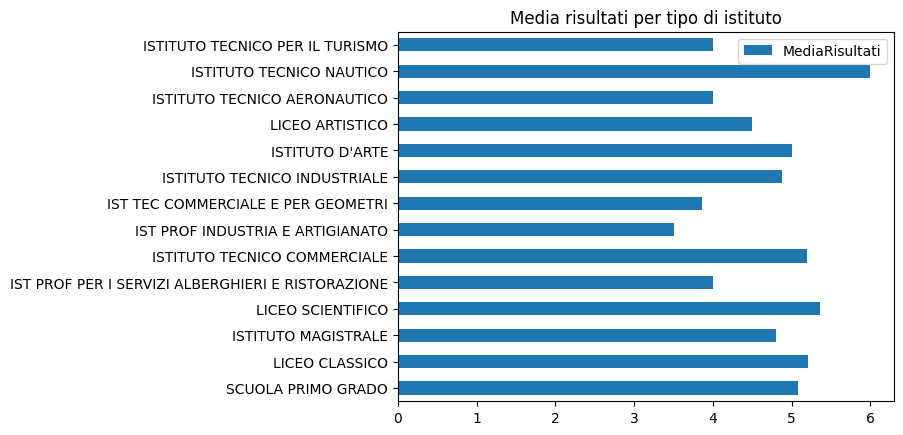

In [278]:


query = """
        SELECT ?TipoIstituto (AVG(?Punteggio) as ?MediaRisultatiScolastici)
        WHERE {
            ?scuola a sso:Scuola .
            ?scuola sso:hasTipoIstituto ?TipoIstituto .
            ?scuola sso:hasValutazione ?valutazione .
            ?valutazione a sso:RisultatiScolastici .
            ?valutazione sso:hasPunteggio ?Punteggio .

        }
        GROUP BY ?TipoIstituto


        """

results = g.query(query)

tipoIstituto = [str(i[0]) for i in results]
mediaRisultati = [float(i[1]) for i in results]

df = pd.DataFrame({'MediaRisultati': mediaRisultati}, index=tipoIstituto).plot(kind='barh', title='Media risultati per tipo di istituto')


Questo grafico mostra la media delle valutazione sui risultati scolastici per ciascun tipo di istituto.

---

### Top 10 scuole con più alunni in Sicilia

<Axes: title={'center': 'Scuole con più alunni'}>

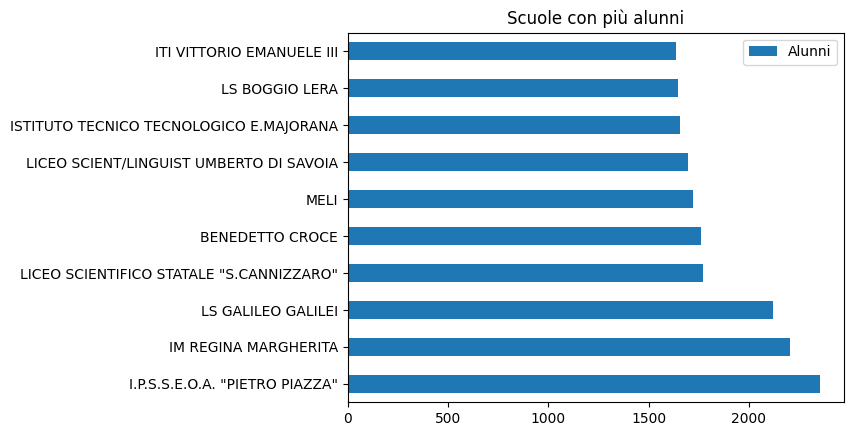

In [279]:

query = """
        SELECT ?nomeScuola ?alunni
        WHERE {
            ?scuola a sso:Scuola ;
                    schema:name ?nomeScuola ;
                    sso:hasAlunni ?alunni .
            
        }
        ORDER BY DESC(?alunni)
        LIMIT 10
        """

results = g.query(query)

scuola = [str(i[0]) for i in results]
alunni = [int(i[1]) for i in results]

pd.DataFrame({'Alunni': alunni}, index=scuola).plot(kind='barh', title='Scuole con più alunni', yticks=range(0, 3000, 100))


Questo grafico mostra le top 10 scuole con più alunni in Sicilia e il rispettivo numero di alunni. Notiamo che la maggior parte di esse sono a Palermo.

---

### Rapporto alunni/classi per ciascun istituto a Palermo

<Axes: title={'center': 'Rapporto alunni classi'}>

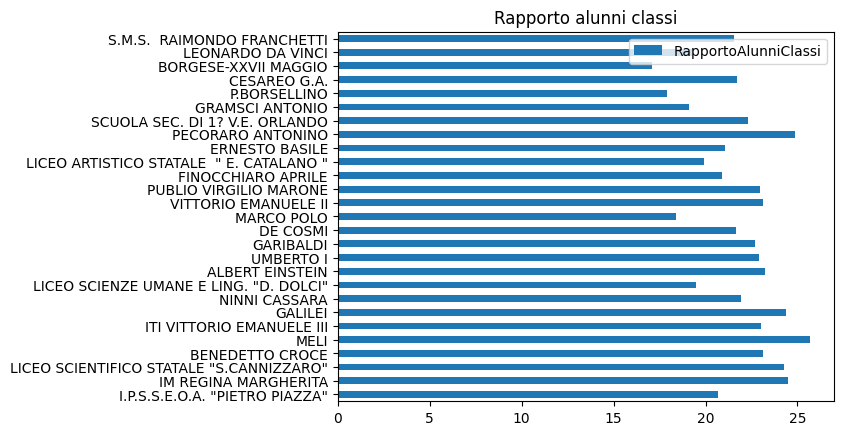

In [280]:

query = """
        SELECT ?nomeScuola ?alunni ?classi
        WHERE {
            ?scuola a sso:Scuola ;
                    schema:name ?nomeScuola ;
                    sso:hasComune ?comune .
            FILTER(?comune =dbpedia:Palermo  || ?comune = 'Palermo') .
            ?scuola sso:hasAlunni ?alunni ;
                    sso:hasClassi ?classi .
            
        }
        ORDER BY DESC(?alunni)
        """

results = g.query(query)

scuola = [str(i[0]) for i in results]
alunni = [int(i[1]) for i in results]
classi = [int(i[2]) for i in results]
rapporto_alunni_classi = [a/c for a, c in zip(alunni, classi)]

pd.DataFrame({'RapportoAlunniClassi': rapporto_alunni_classi}, index=scuola).plot(kind='barh', title='Rapporto alunni classi')


Dopo aver visto i risultati del grafico precedente abbiamo voluto vedere il tasso di riempimento delle classi nelle scuole a Palermo per vedere se c'era un sovraaffollamento. Mostriamo qui il rapporto alunni/numero classi per ciascun istituto di Palermo. Notiamo come alcune scuole hanno una media di più di 25 alunni per classe! 

---

### Confronto media numero alunni degli istituti per ciascun comune con gli istituti del comune stesso

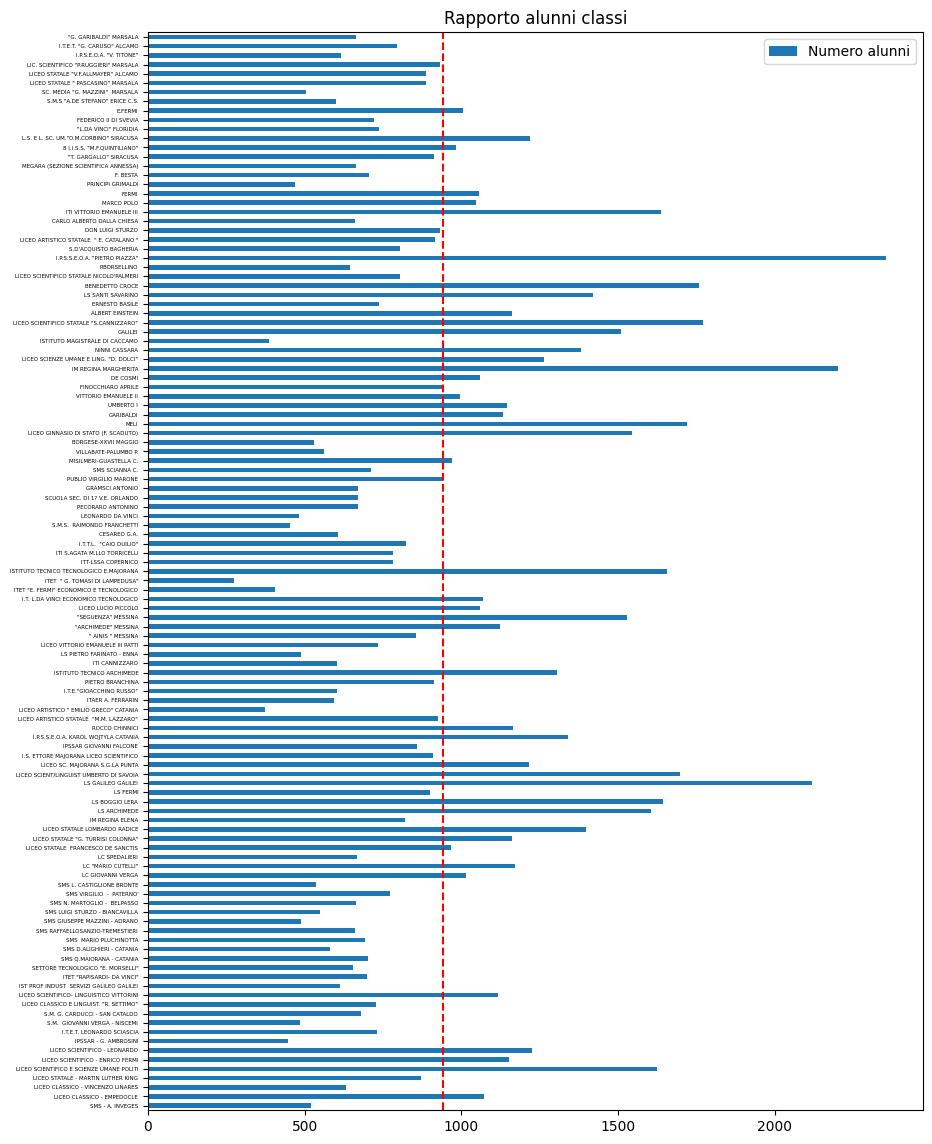

In [281]:
query = """
        SELECT ?nomeScuola (SUM(?alunni) as ?totaleAlunni)
        WHERE {
            ?scuola a sso:Scuola ;
            schema:name ?nomeScuola;
            sso:hasAlunni ?alunni .
        }
        GROUP BY ?nomeScuola
        """


results1 = g.query(query)


query = """
        SELECT (AVG(?alunni) as ?avgAlunni)
        WHERE {
            ?scuola a sso:Scuola ;
                schema:name ?nomeScuola;
                sso:hasAlunni ?alunni .
        }
        """

results2 = g.query(query)
avgAlunni = round(float(list(results2)[0].avgAlunni), 2)

scuola = [str(i[0]) for i in results1]
alunni = [int(i[1]) for i in results1]

ax = pd.DataFrame({'Numero alunni': alunni}, index=scuola).plot(kind='barh', title='Rapporto alunni classi', figsize=(10,14))
ax.axvline(avgAlunni, color='red', linestyle='--')
ax.yaxis.set_tick_params(labelsize = 4)

Infine mostriamo il confronto tra il numero di alunni in ciascun istituto e la media di alunni in tutta la sicilia.

# __`5. Mappa istituti sicilia con uMap`__ 

In [283]:
from IPython.display import IFrame

url = "https://umap.openstreetmap.fr/it/map/scuole-sicilia_1084546"

IFrame(url, width=800, height=600)
